INFO:__main__:Initializing kagglehub to load dataset...
INFO:__main__:Successfully loaded dataset with 7043 records
INFO:__main__:Starting data exploration...


First 5 records:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No   

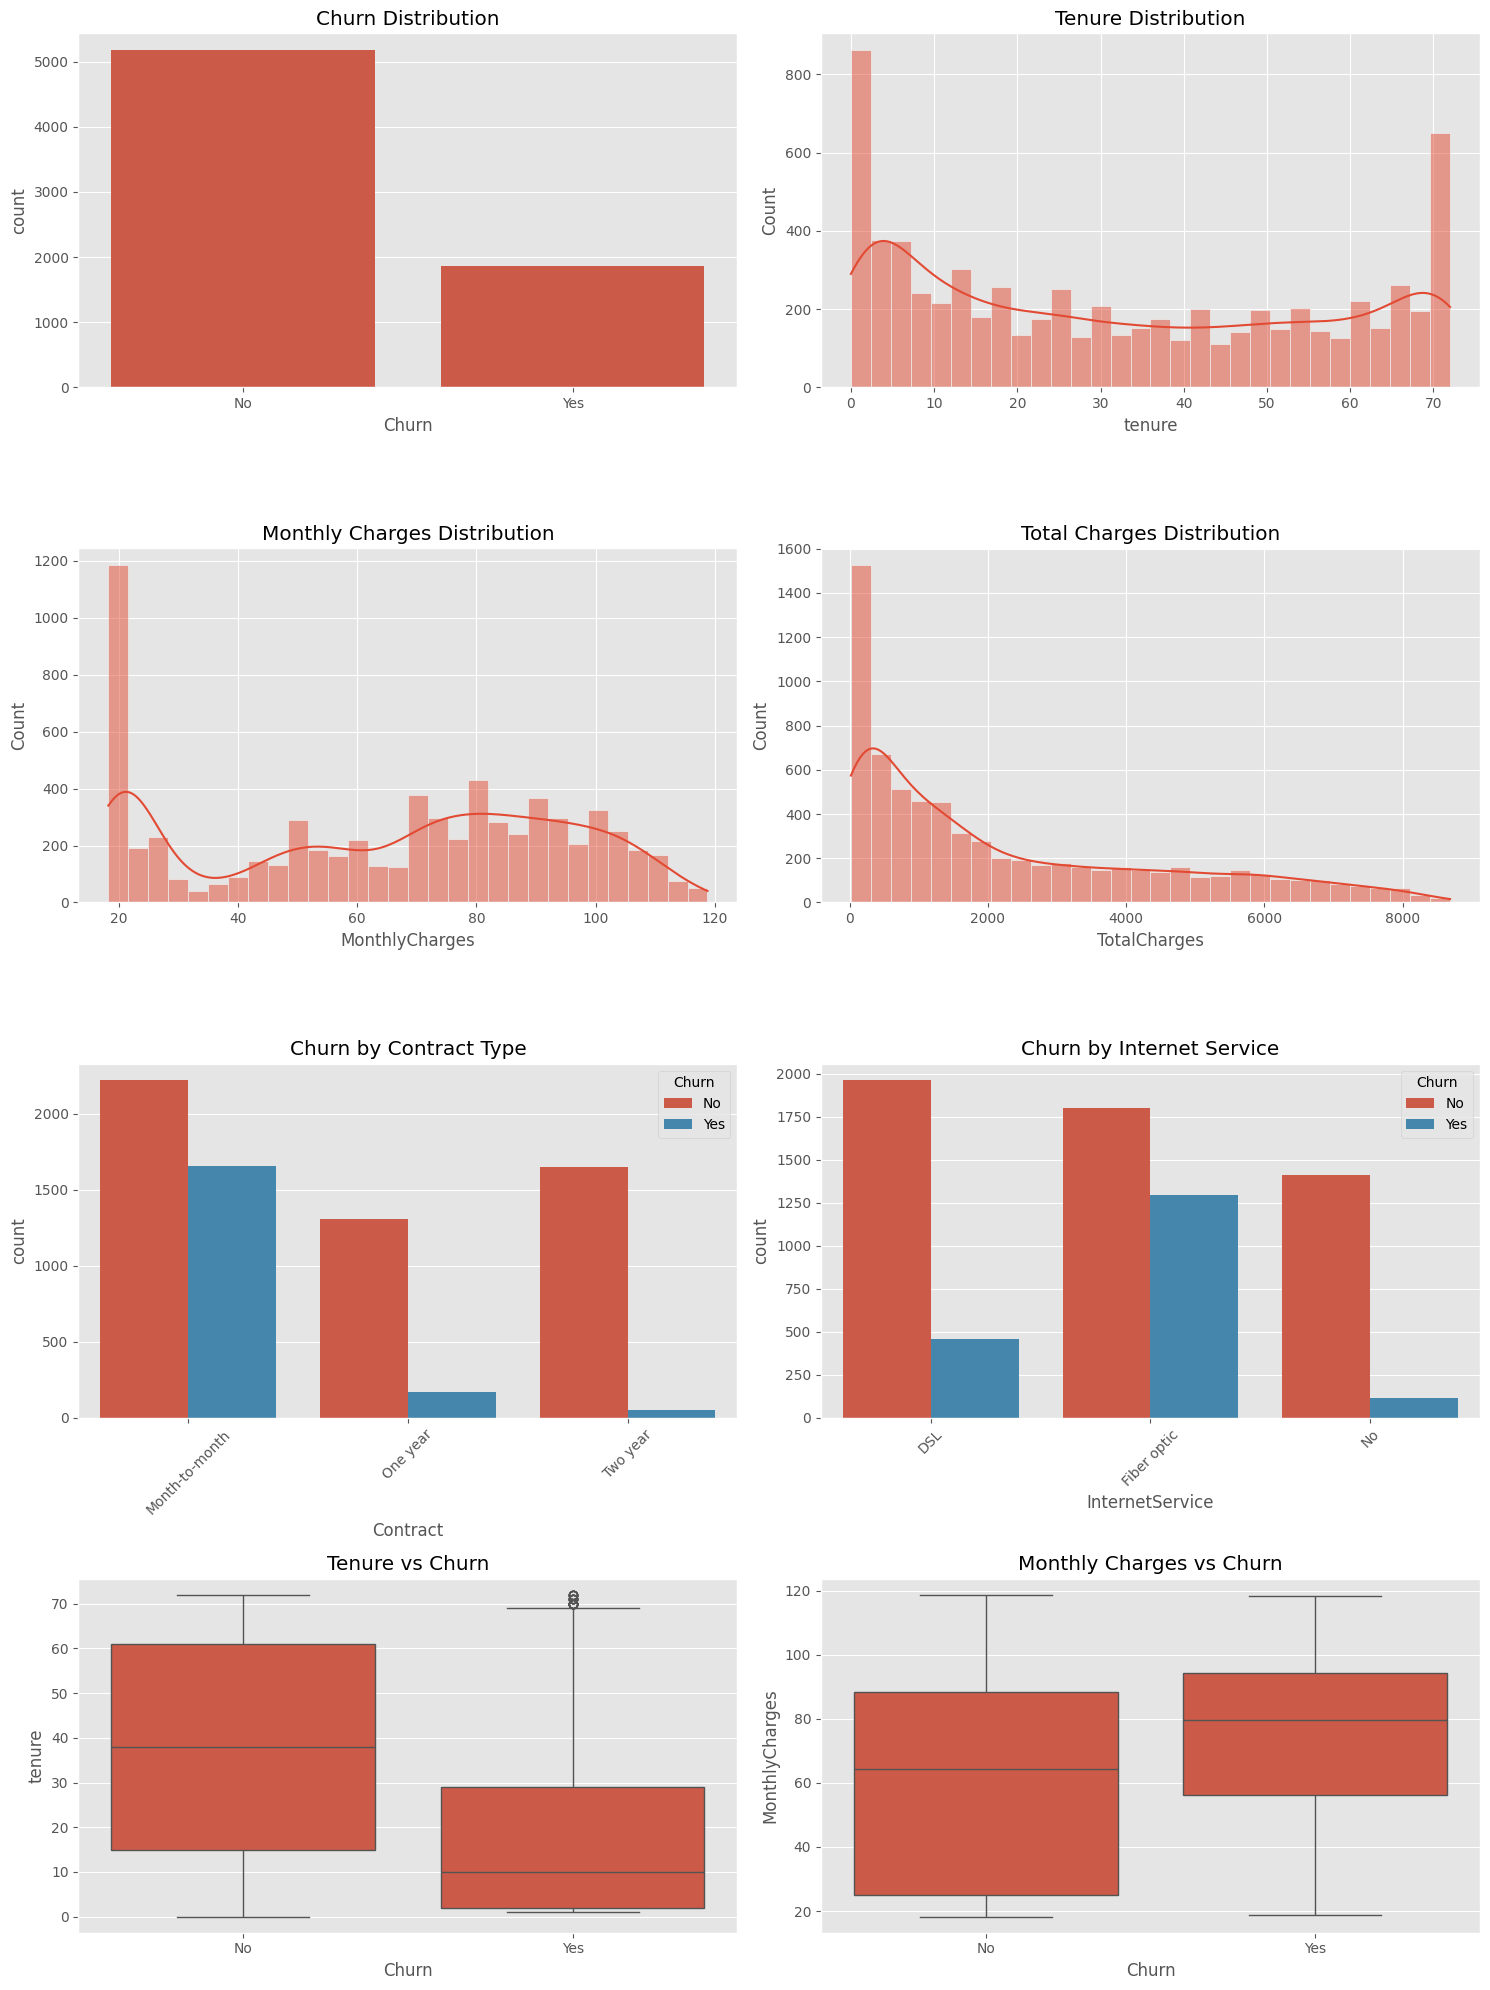

INFO:__main__:Data exploration completed
INFO:__main__:Starting data preprocessing...
INFO:__main__:Data preprocessing completed
INFO:__main__:Engineering new features...
INFO:__main__:Added 4 new features. Total features now: 35
INFO:__main__:Training models...
INFO:__main__:Performing cross-validation...



Class distribution after SMOTE: Churn
0    5174
1    5174
Name: count, dtype: int64


INFO:__main__:Tuning hyperparameters...



Random Forest CV F1: 0.841 (±0.009)
XGBoost CV F1: 0.837 (±0.011)


INFO:__main__:Evaluating Random Forest...



Best Random Forest parameters:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Best XGBoost parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Random Forest Performance:
Accuracy: 0.847
Precision: 0.825
Recall: 0.882
F1 Score: 0.852
ROC AUC: 0.919


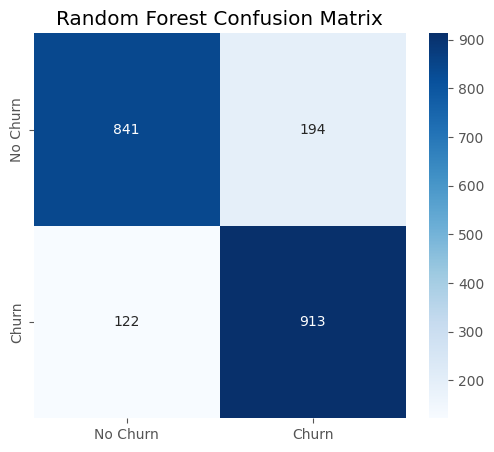

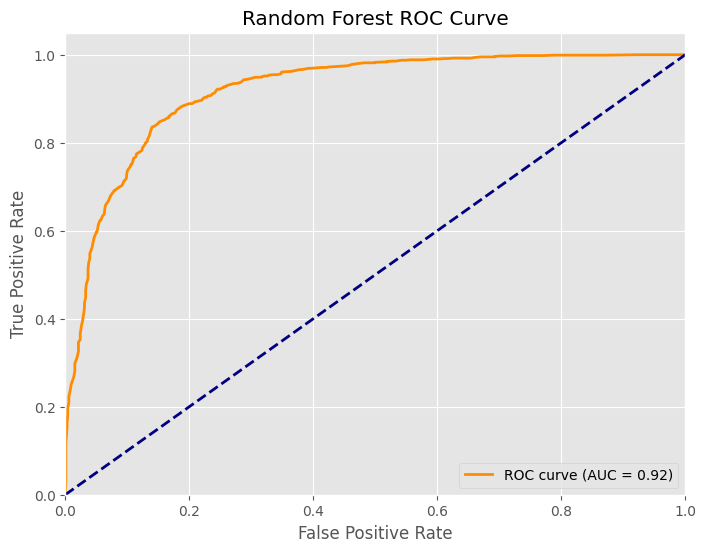

INFO:__main__:Evaluating XGBoost...



XGBoost Performance:
Accuracy: 0.833
Precision: 0.809
Recall: 0.873
F1 Score: 0.840
ROC AUC: 0.914


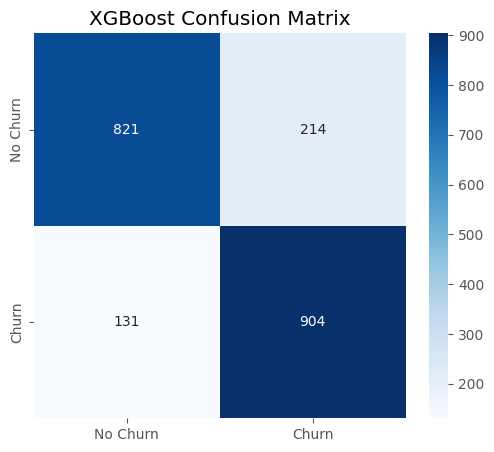

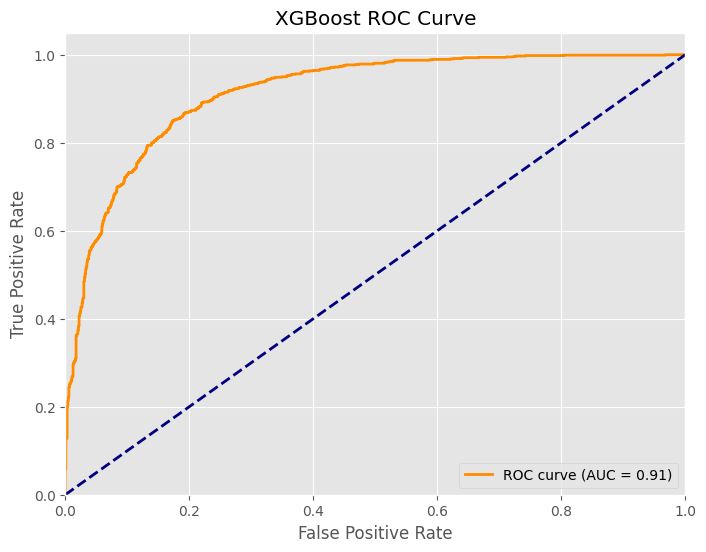

INFO:__main__:Interpreting XGBoost...


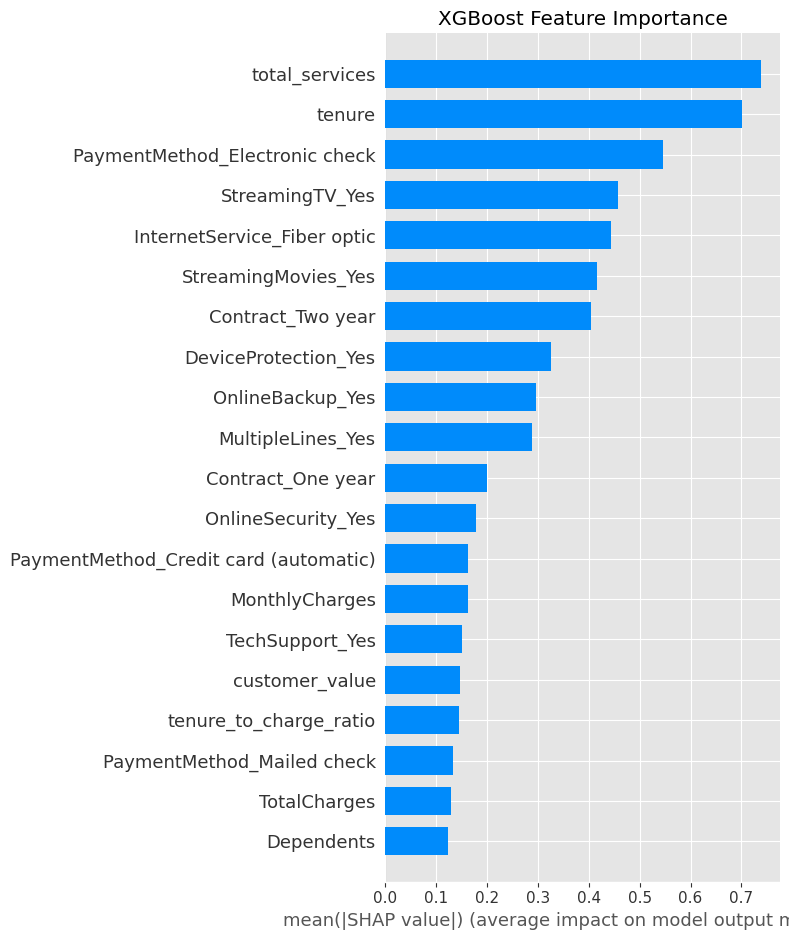

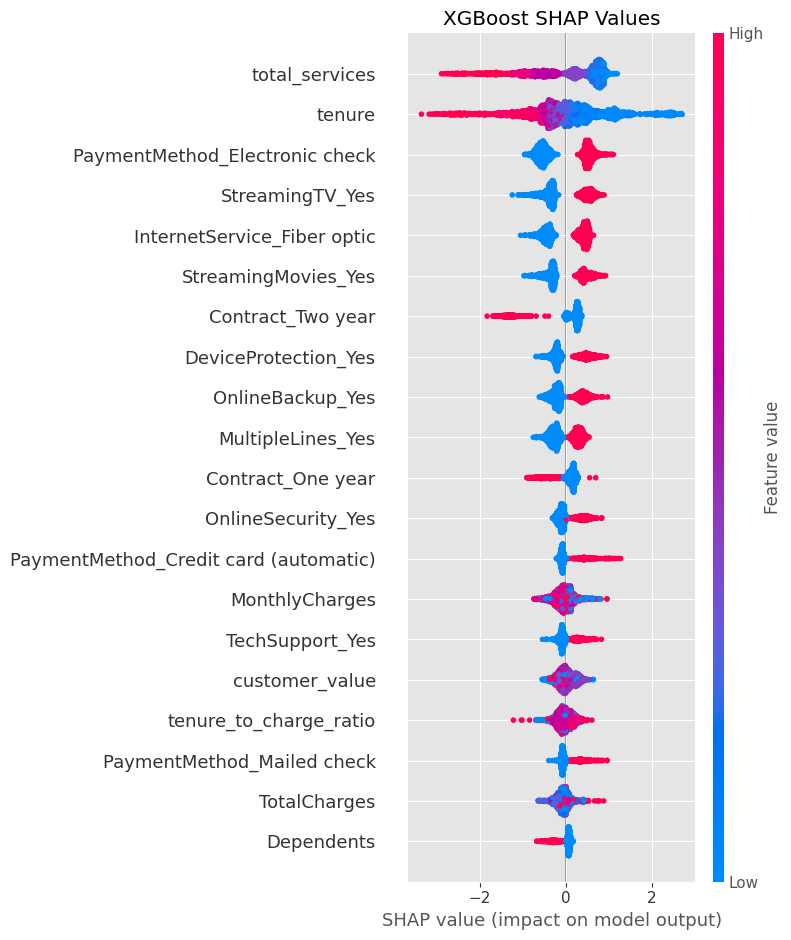


=== Business Recommendations ===
1. Focus retention efforts on customers with month-to-month contracts
2. Target customers with high monthly charges but low tenure
3. Bundle services to increase customer stickiness
4. Offer loyalty discounts to long-tenured customers
5. Improve tech support for customers with multiple services


In [1]:
# -*- coding: utf-8 -*-
"""
Telco Customer Churn Prediction Project
Applied Machine Learning Exam - Uganda Christian University
"""

# =====================
# 1. SETUP AND IMPORTS
# =====================
import os
import logging
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           roc_curve, auc)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# =====================
# 2. DATA LOADING
# =====================
def load_data():
    """Load and validate the Telco Customer Churn dataset using kagglehub"""
    try:
        logger.info("Initializing kagglehub to load dataset...")
        
        # Specify the file path for the dataset
        file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
        
        # Load the dataset using kagglehub
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "blastchar/telco-customer-churn",
            file_path,
            pandas_kwargs={'encoding': 'utf-8', 'na_values': [' ', 'NA', 'N/A', '']}
        )
        
        # Validate dataset
        if df.empty:
            raise ValueError("Empty dataset loaded")
            
        expected_cols = {'customerID', 'gender', 'SeniorCitizen', 'Partner', 
                        'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 
                        'StreamingMovies', 'Contract', 'PaperlessBilling', 
                        'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'}
        
        if not expected_cols.issubset(df.columns):
            missing = expected_cols - set(df.columns)
            raise ValueError(f"Missing columns: {missing}")
            
        logger.info(f"Successfully loaded dataset with {len(df)} records")
        print(f"First 5 records:\n{df.head()}")
        return df
        
    except Exception as e:
        logger.error(f"Data loading failed: {str(e)}")
        print("Failed to load data. Ensure kagglehub is set up correctly:")
        print("- Place 'kaggle.json' in C:\\Users\\LENOVO\\.kaggle")
        print("- Or set KAGGLE_USERNAME and KAGGLE_KEY environment variables")
        print("See: https://github.com/Kaggle/kagglehub#installation")
        print("Alternatively, download the dataset manually from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
        raise

# =====================
# 3. DATA EXPLORATION
# =====================
def explore_data(df):
    """Perform exploratory data analysis"""
    logger.info("Starting data exploration...")
    
    # Basic info
    print("\n=== Dataset Information ===")
    print(f"Shape: {df.shape}")
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isna().sum())
    
    # Visualizations
    plt.figure(figsize=(15, 20))
    
    # 1. Target distribution
    plt.subplot(4, 2, 1)
    sns.countplot(x='Churn', data=df)
    plt.title('Churn Distribution')
    
    # 2. Numerical features
    plt.subplot(4, 2, 2)
    sns.histplot(df['tenure'], bins=30, kde=True)
    plt.title('Tenure Distribution')
    
    plt.subplot(4, 2, 3)
    sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
    plt.title('Monthly Charges Distribution')
    
    plt.subplot(4, 2, 4)
    sns.histplot(df['TotalCharges'].replace(' ', np.nan).astype(float), bins=30, kde=True)
    plt.title('Total Charges Distribution')
    
    # 3. Categorical features
    plt.subplot(4, 2, 5)
    sns.countplot(x='Contract', hue='Churn', data=df)
    plt.title('Churn by Contract Type')
    plt.xticks(rotation=45)
    
    plt.subplot(4, 2, 6)
    sns.countplot(x='InternetService', hue='Churn', data=df)
    plt.title('Churn by Internet Service')
    plt.xticks(rotation=45)
    
    plt.subplot(4, 2, 7)
    sns.boxplot(x='Churn', y='tenure', data=df)
    plt.title('Tenure vs Churn')
    
    plt.subplot(4, 2, 8)
    sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
    plt.title('Monthly Charges vs Churn')
    
    plt.tight_layout()
    plt.savefig('data_exploration.png', dpi=300)
    plt.show()
    
    logger.info("Data exploration completed")

# =====================
# 4. DATA PREPROCESSING
# =====================
def preprocess_data(df):
    """Clean and preprocess the data"""
    logger.info("Starting data preprocessing...")
    
    # Handle missing values
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(0, inplace=True)
    
    # Convert Churn to binary
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    
    # Drop customer ID (not useful for modeling)
    df.drop('customerID', axis=1, inplace=True)
    
    # Encode categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Binary encoding for columns with 2 categories
    binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]
    for col in binary_cols:
        df[col] = LabelEncoder().fit_transform(df[col])
    
    # One-hot encoding for other categorical variables
    other_cat_cols = [col for col in categorical_cols if df[col].nunique() > 2]
    df = pd.get_dummies(df, columns=other_cat_cols, drop_first=True)
    
    # Feature scaling
    numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    logger.info("Data preprocessing completed")
    return df

# =====================
# 5. FEATURE ENGINEERING
# =====================
def engineer_features(df):
    """Create new features"""
    logger.info("Engineering new features...")
    
    # 1. Tenure to charges ratio
    df['tenure_to_charge_ratio'] = df['tenure'] / (df['MonthlyCharges'] + 0.01)
    
    # 2. Total services used
    services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies']
    df['total_services'] = df[[f"{s}_Yes" for s in services]].sum(axis=1)
    
    # 3. Customer value (monthly charges * tenure)
    df['customer_value'] = df['MonthlyCharges'] * (df['tenure'] + 1)
    
    # 4. Interaction between tenure and contract
    df['tenure_contract_interaction'] = df['tenure'] * df['Contract_Two year']
    
    logger.info(f"Added 4 new features. Total features now: {len(df.columns)}")
    return df

# =====================
# 6. MODEL TRAINING
# =====================
def train_models(X_train, y_train):
    """Train and tune machine learning models"""
    logger.info("Training models...")
    
    # Initialize models
    rf = RandomForestClassifier(random_state=42)
    xgb = XGBClassifier(random_state=42, eval_metric='logloss')
    
    # Cross-validation
    logger.info("Performing cross-validation...")
    rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
    xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1')
    
    print(f"\nRandom Forest CV F1: {rf_scores.mean():.3f} (±{rf_scores.std():.3f})")
    print(f"XGBoost CV F1: {xgb_scores.mean():.3f} (±{xgb_scores.std():.3f})")
    
    # Hyperparameter tuning
    logger.info("Tuning hyperparameters...")
    
    # Random Forest parameters
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    
    # XGBoost parameters
    xgb_params = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0]
    }
    
    # Grid search
    rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
    xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='f1', n_jobs=-1)
    
    rf_grid.fit(X_train, y_train)
    xgb_grid.fit(X_train, y_train)
    
    print("\nBest Random Forest parameters:")
    print(rf_grid.best_params_)
    print("\nBest XGBoost parameters:")
    print(xgb_grid.best_params_)
    
    return rf_grid.best_estimator_, xgb_grid.best_estimator_

# =====================
# 7. MODEL EVALUATION
# =====================
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    logger.info(f"Evaluating {model_name}...")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }
    
    print(f"\n{model_name} Performance:")
    for name, value in metrics.items():
        print(f"{name}: {value:.3f}")
    
    # Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(f'{model_name.lower()}_confusion_matrix.png', dpi=300)
    plt.show()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'{model_name.lower()}_roc_curve.png', dpi=300)
    plt.show()
    
    return metrics

# =====================
# 8. MODEL INTERPRETATION
# =====================
def interpret_model(model, X_test, model_name):
    """Explain model predictions using SHAP"""
    logger.info(f"Interpreting {model_name}...")
    
    try:
        # SHAP explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        # Summary plot
        plt.figure()
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        plt.title(f'{model_name} Feature Importance')
        plt.tight_layout()
        plt.savefig(f'{model_name.lower()}_feature_importance.png', dpi=300)
        plt.show()
        
        # Detailed summary plot
        plt.figure()
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title(f'{model_name} SHAP Values')
        plt.tight_layout()
        plt.savefig(f'{model_name.lower()}_shap_values.png', dpi=300)
        plt.show()
        
    except Exception as e:
        logger.error(f"SHAP interpretation failed: {str(e)}")

# =====================
# 9. MAIN WORKFLOW
# =====================
def main():
    """Main project workflow"""
    try:
        # 1. Load data
        df = load_data()
        
        # 2. Explore data
        explore_data(df)
        
        # 3. Preprocess data
        df = preprocess_data(df)
        
        # 4. Feature engineering
        df = engineer_features(df)
        
        # 5. Handle class imbalance
        X = df.drop('Churn', axis=1)
        y = df['Churn']
        
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X, y)
        print(f"\nClass distribution after SMOTE: {pd.Series(y_res).value_counts()}")
        
        # 6. Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
        
        # 7. Model training
        rf_model, xgb_model = train_models(X_train, y_train)
        
        # 8. Model evaluation
        rf_metrics = evaluate_model(rf_model, X_test, y_test, "Random Forest")
        xgb_metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
        
        # 9. Model interpretation
        interpret_model(xgb_model, X_test, "XGBoost")
        
        # 10. Business recommendations
        print("\n=== Business Recommendations ===")
        print("1. Focus retention efforts on customers with month-to-month contracts")
        print("2. Target customers with high monthly charges but low tenure")
        print("3. Bundle services to increase customer stickiness")
        print("4. Offer loyalty discounts to long-tenured customers")
        print("5. Improve tech support for customers with multiple services")
        
    except Exception as e:
        logger.error(f"Project failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()